In [14]:
cd("/Users/usuario/Desktop/biophys/0_scripts/julia")

using Parameters, CSV, DataFrames, Roots, Plots

include("aux_functions.jl")
include("organism.jl")
include("environment.jl")
include("geometry.jl")
include("qmet.jl")
include("qrin.jl")
include("qrout.jl")
include("qsolar.jl")
include("qcond.jl")
include("convection.jl")
include("skinevap.jl")
include("resp.jl")
include("fun_nmr_obj.jl")


# Read environmental data
metout = CSV.read("./simulation/metout.csv", DataFrame, normalizenames=true);
soil = CSV.read("./simulation/soil.csv", DataFrame, normalizenames=true);
tcond = CSV.read("./simulation/tcond.csv", DataFrame, normalizenames=true);

# create environmental data object: Parameters
env = envParams(αsub = 0.85, elev = 251);


# Define organism (parameters and state variables) 
anim = organismParams(Ww_g = 30, pct_cond = 30, postur = 0, pant=0, M1=0);
state = stateVars();


tbs = []
for i in 1:size(metout, 1)
    global vars = envVariables(Ta = [metout.TALOC[i]], 
                        Tsub = [soil.DEP1[i]], 
                        TGRD = [soil.DEP1[i]], 
                        Tsky = [metout.TSKYC[i]], 
                        vel = [metout.VLOC[i]], 
                        rh = [metout.RHLOC[i]], 
                        QSOLR = [metout.SOLR[i]], 
                        zen = [metout.ZEN[i]], 
                        ksub = [tcond.CD1[i]]);
    
    global Qrin = qrin(anim, env, vars)
    global Qsolar = qsolar(anim, env, vars, vars.QSOLR[1]).Qsolar
    tb = find_zero(fun_nmr, (-50, 100), Bisection())
    push!(tbs, tb)
end


anim = organismParams(Ww_g = 30, pct_cond = 30, postur = 0, pant=0, M1=0, pct_wet=80)
tbs_80 = []
for i in 1:size(metout, 1)
    global vars = envVariables(Ta = [metout.TALOC[i]], 
                        Tsub = [soil.DEP1[i]], 
                        TGRD = [soil.DEP1[i]], 
                        Tsky = [metout.TSKYC[i]], 
                        vel = [metout.VLOC[i]], 
                        rh = [metout.RHLOC[i]], 
                        QSOLR = [metout.SOLR[i]], 
                        zen = [metout.ZEN[i]], 
                        ksub = [tcond.CD1[i]]);
    
    global Qrin = qrin(anim, env, vars)
    global Qsolar = qsolar(anim, env, vars, vars.QSOLR[1]).Qsolar
    tb = find_zero(fun_nmr, (-50, 100), Bisection())
    push!(tbs_80, tb)
end


# read nichemapR predictions
TCnmr = CSV.read("./simulation/TCnmr.csv", DataFrame);
TCnmr_wet80 = CSV.read("./simulation/TCnmr_wet80.csv", DataFrame);

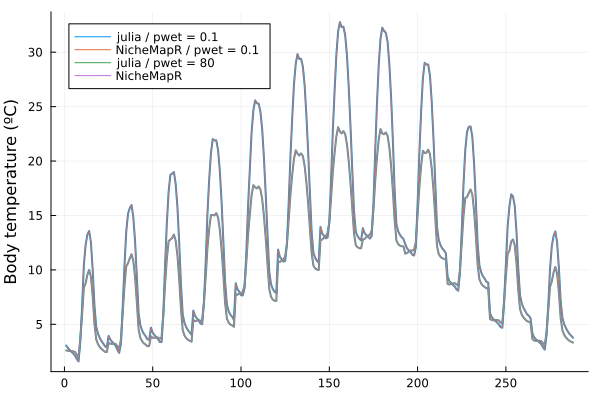

In [15]:

plot(tbs, label = "julia / pwet = 0.1", linewidth = 2, dpi = 300, legend = :topleft)
plot!(TCnmr.x, label = "NicheMapR / pwet = 0.1")
plot!(tbs_80, label = "julia / pwet = 80", linewidth = 2)
plot!(TCnmr_wet80.x, label = "NicheMapR")
ylabel!("Body temperature (ºC)")
# # savefig("sim3_vs_nmr.png")

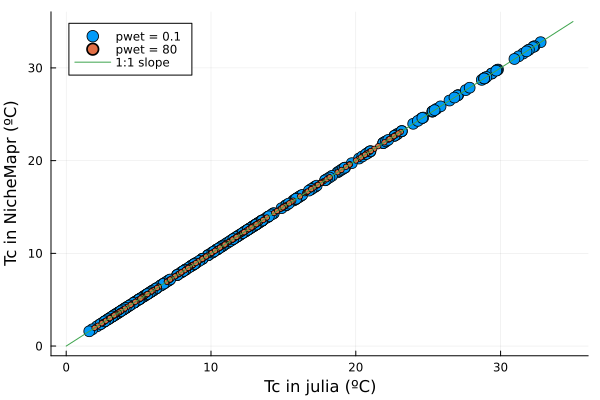

In [16]:
scatter(tbs, TCnmr.x, markersize = 6, legend = :topleft, label = "pwet = 0.1")
scatter!(tbs_80, TCnmr_wet80.x, markersize = 3, label = "pwet = 80")
plot!(0:35, 0:35, linewidth = 1, label = "1:1 slope")
xlabel!("Tc in julia (ºC)")
ylabel!("Tc in NicheMapr (ºC)")
# # savefig("sim3_vs_nmr_scatter.png")

In [17]:

maximum(tbs) - maximum(TCnmr.x)

-0.0073687927427670274

In [18]:
minimum(tbs) - minimum(TCnmr.x)

0.0004399133310131198